In [ ]:
!pip install --quiet neural-structured-learning

In [1]:
import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf

In [2]:
import os
import pandas as pd

In [3]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, "data", "birdclef-2021-parsed", "train_short_audio")
birdList = os.listdir(data_dir)

In [4]:
IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                    validation_split=0.2,
                                                                    seed=123,
                                                                    subset="training",                                                                
                                                                    labels='inferred',
                                                                    batch_size=32,
                                                                    color_mode="grayscale",
                                                                    image_size=(128, 256))

Found 893740 files belonging to 397 classes.
Using 714992 files for training.


In [6]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                    validation_split=0.2,
                                                                    seed=123,
                                                                    subset="validation",                                                                
                                                                    labels='inferred',
                                                                    batch_size=32,
                                                                    color_mode="grayscale",
                                                                    image_size=(128, 256))

Found 893740 files belonging to 397 classes.
Using 178748 files for validation.


In [7]:
train_dataset.class_names[390:]

['yehcar1', 'yelgro', 'yelwar', 'yeofly1', 'yerwar', 'yeteup1', 'yetvir']

In [8]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 128, 256, 1), (None,)), types: (tf.float32, tf.int32)>

In [9]:
len(train_dataset)

22344

In [20]:
import pickle
variableFolder = os.path.join(cwd, "variables")
fileWeights = os.path.join(variableFolder, "weights.pickle")
with open(fileWeights, 'rb') as fW:
    birdWeights = pickle.load(fW)
fW.close()

In [24]:
class_weights = {index:birdWeights[iBird] for index, iBird in enumerate(train_dataset.class_names)}

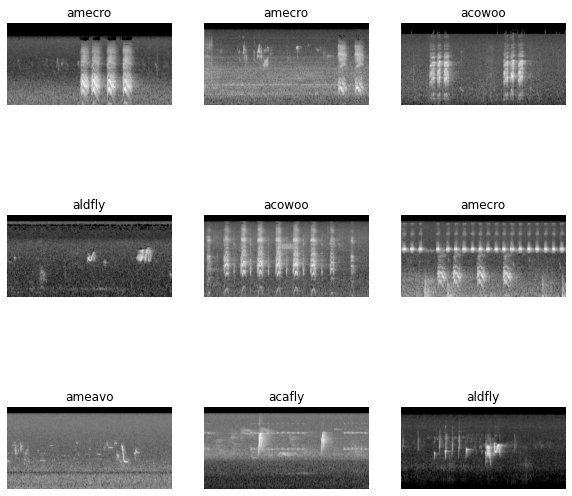

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(train_dataset.class_names[labels[i]])
    plt.axis("off")

In [11]:
class HParams(object):
  def __init__(self):
    self.input_shape = [128, 256, 1]
    self.num_classes = 397
    self.conv_filters = [32, 64, 64]
    self.kernel_size = (3, 3)
    self.pool_size = (2, 2)
    self.num_fc_units = [64]
    self.batch_size = 32
    self.epochs = 5
    self.adv_multiplier = 0.2
    self.adv_step_size = 0.2
    self.adv_grad_norm = 'infinity'

HPARAMS = HParams()

## Base model implementation

In [12]:
def build_base_model(hparams):
  """Builds a model according to the architecture defined in `hparams`."""
  inputs = tf.keras.Input(
      shape=hparams.input_shape, dtype=tf.float32, name=IMAGE_INPUT_NAME)

  x = inputs
  for i, num_filters in enumerate(hparams.conv_filters):
    x = tf.keras.layers.Conv2D(
        num_filters, hparams.kernel_size, activation='relu')(
            x)
    if i < len(hparams.conv_filters) - 1:
      # max pooling between convolutional layers
      x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
  x = tf.keras.layers.Flatten()(x)
  for num_units in hparams.num_fc_units:
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
  pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=pred)
  return model

In [13]:
base_model = build_base_model(HPARAMS)
base_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 128, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 127, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 125, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 60, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 107520)           

## Base model training

In [ ]:
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])
base_model.fit(train_dataset, epochs=HPARAMS.epochs, class_weight=class_weights)

## Base model testing

In [14]:
results = base_model.evaluate(test_dataset)
named_results = dict(zip(base_model.metrics_names, results))
print('\naccuracy:', named_results['acc'])

5/5 [==============================] - 0s 64ms/step - loss: 1.3264 - acc: 0.4868

accuracy: 0.4868420958518982


## Adversarial model

In [15]:
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=HPARAMS.adv_multiplier,
    adv_step_size=HPARAMS.adv_step_size,
    adv_grad_norm=HPARAMS.adv_grad_norm
)

In [24]:
def convert_to_dictionaries(image, label):
    label = tf.cast(label, dtype=tf.float32)
    return {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label}

In [25]:
train_set_for_adv_model = train_dataset.map(convert_to_dictionaries)
test_set_for_adv_model = test_dataset.map(convert_to_dictionaries)

In [26]:
train_set_for_adv_model.take(1)

<TakeDataset shapes: {image: (None, 128, 256, 1), label: (None,)}, types: {image: tf.float32, label: tf.float32}>

In [27]:
base_adv_model = build_base_model(HPARAMS)
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config
)

In [28]:
adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])
adv_model.fit(train_set_for_adv_model, epochs=HPARAMS.epochs)

Epoch 1/5
20/20 [==============================] - 4s 222ms/step - loss: 33.7264 - sparse_categorical_crossentropy: 27.9921 - sparse_categorical_accuracy: 0.3170 - scaled_adversarial_loss: 5.7342
Epoch 2/5
20/20 [==============================] - 3s 151ms/step - loss: 1.7265 - sparse_categorical_crossentropy: 1.4270 - sparse_categorical_accuracy: 0.4281 - scaled_adversarial_loss: 0.2995
Epoch 3/5
20/20 [==============================] - 3s 156ms/step - loss: 1.4976 - sparse_categorical_crossentropy: 1.2374 - sparse_categorical_accuracy: 0.4592 - scaled_adversarial_loss: 0.2602
Epoch 4/5
20/20 [==============================] - 3s 155ms/step - loss: 1.4092 - sparse_categorical_crossentropy: 1.1635 - sparse_categorical_accuracy: 0.4722 - scaled_adversarial_loss: 0.2457
Epoch 5/5
20/20 [==============================] - 3s 150ms/step - loss: 1.5861 - sparse_categorical_crossentropy: 1.3093 - sparse_categorical_accuracy: 0.4657 - scaled_adversarial_loss: 0.2768


In [29]:
results = adv_model.evaluate(test_set_for_adv_model)
named_results = dict(zip(adv_model.metrics_names, results))
print('\naccuracy:', named_results['sparse_categorical_accuracy'])

5/5 [==============================] - 1s 114ms/step - loss: 1.8007 - sparse_categorical_crossentropy: 1.4948 - sparse_categorical_accuracy: 0.4079 - scaled_adversarial_loss: 0.3059

accuracy: 0.40789473056793213


In [30]:
reference_model = nsl.keras.AdversarialRegularization(
    base_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config)
reference_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc'])

In [31]:
models_to_eval = {
    'base': base_model,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

In [32]:
perturbed_images, labels, predictions = [], [], []

for batch in test_set_for_adv_model:
  perturbed_batch = reference_model.perturb_on_batch(batch)
  # Clipping makes perturbed examples have the same range as regular ones.
  perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(                          
      perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)
  y_true = perturbed_batch.pop(LABEL_INPUT_NAME)
  perturbed_images.append(perturbed_batch[IMAGE_INPUT_NAME].numpy())
  labels.append(y_true.numpy())
  predictions.append({})
  for name, model in models_to_eval.items():
    y_pred = model(perturbed_batch)
    metrics[name](y_true, y_pred)
    predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
  print('%s model accuracy: %f' % (name, metric.result().numpy()))

base model accuracy: 0.256579
adv-regularized model accuracy: 0.223684
